# Sentiment Classification Using RNNs

* Given the IMDB Movie Review Dataset, create an RNN model that predicts whether the given review is negative or positive.
* You need to create your Dataset, Dataloader and Model. Keep your code modular and avoid hardcoding any parameter. This will allow you to experiment more easily.
* Plot graphs for loss and accuracy for each epoch of a training loop. Try using wandb for logging training and validation losses, accuracies.
* Use tqdm to keep track of the status of the training loop for an epoch

### 1. RNN Model
#### 1.1 Build a Dataset from the IMDB Movie Review Dataset by taking reviews with word count between 100 and 500. Perform text processing on the movie reviews and create a word to index mapping for representing any review as a list of numbers.
#### 1.2 Create Dataloaders for the train, test and validation datasets with appropriate batch sizes.
#### 1.3 Create the Model class for the RNN Model. Create functions for running model training and testing.

In [1]:
!pip install datasets torchmetrics

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm

In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
SEED = 1234

# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
imdb_dataset = load_dataset("imdb")


train_dataset = imdb_dataset['train'].train_test_split(test_size=0.2, seed=SEED)
train_data = train_dataset['train']
val_data = train_dataset['test']
test_data = imdb_dataset['test']

print(f"Train dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(val_data)}")
print(f"Test dataset size: {len(test_data)}")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Train dataset size: 20000
Validation dataset size: 5000
Test dataset size: 25000


In [7]:
# def clean(text, tokenizer):
#   # Perform text preprocessing:
#   # 1. Removing numbers OR replace them with "num" token
#   # 2. Convert all characters to lowercase.
#   # 3. Tokenize the sentence into words
#   # You can use RegexpTokenizer from NLTK.

#   # You will experiment with stemming/lemmatization down the line
#   # so you can skip that for now

#   text = text.lower()  # Convert to lowercase
#   text = re.sub(r'\d+', 'num', text)  # Replace digits with 'num'
#   tokens = tokenizer.tokenize(text)  # Tokenize text
#   return tokens


def clean(text, tokenizer, lemmatize=False, stem=False):
    # Perform text preprocessing:
    # 1. Removing numbers OR replace them with "num" token
    # 2. Convert all characters to lowercase.
    # 3. Tokenize the sentence into words
    # 4. Perform stemming or lemmatization based on the parameters
    
    text = re.sub(r'\d+', 'num', text)  # Replace numbers with 'num' token
    text = text.lower()  # Convert to lowercase
    tokens = tokenizer.tokenize(text)  # Tokenize using the provided tokenizer
    
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    elif stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens


In [8]:
# try:
#     nltk.data.find('wordnet')
# except:
import subprocess
print(nltk.data.path)
nltk.download('wordnet', download_dir='/root/nltk_data/')
command = "unzip /root/nltk_data/corpora/wordnet.zip -d /root/nltk_data/corpora"
subprocess.run(command.split())
nltk.data.path.append('/root/nltk_data/')

['/root/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']
[nltk_data] Downloading package wordnet to /root/nltk_data/...
Archive:  /root/nltk_data/corpora/wordnet.zip
   creating: /root/nltk_data/corpora/wordnet/
  inflating: /root/nltk_data/corpora/wordnet/lexnames  
  inflating: /root/nltk_data/corpora/wordnet/data.verb  
  inflating: /root/nltk_data/corpora/wordnet/index.adv  
  inflating: /root/nltk_data/corpora/wordnet/adv.exc  
  inflating: /root/nltk_data/corpora/wordnet/index.verb  
  inflating: /root/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /root/nltk_data/corpora/wordnet/data.adj  
  inflating: /root/nltk_data/corpora/wordnet/index.adj  
  inflating: /root/nltk_data/corpora/wordnet/LICENSE  
  inflating: /root/nltk_data/corpora/wordnet/citation.bib  
  inflating: /root/nltk_data/corpora/wordnet/noun.exc  
  inflating: /root/nltk_data/corpora/wordnet/verb.exc  
  inflating: /root/nltk_data/corpora/wo

In [9]:
clean("This IS 1 example sentence.", RegexpTokenizer(r'\w+'))

['this', 'is', 'num', 'example', 'sentence']

In [10]:
# create a word to index dictionary so that each word in the training set
# has a number associated with it. This allows to represent each sentence
# as a series of numbers. Start the index with 1 instead of 0. The number
# 0 will be used to denote padding, so that each sentence can have the
# same length.
# Keep track of the index since it will be used for representing new words
# that were not part of the training vocabulary.
# Also, make sure to not create dictionary on sentences with word count
# not within the range

tokenizer = RegexpTokenizer(r'\w+')

def get_word2idx(corpus, lemmatize=False, stem=False):
  word2idx = {}
  idx = 1
  for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
      tokens = clean(sentence, tokenizer, lemmatize=lemmatize, stem=stem)
      for token in tokens:
          if token not in word2idx:
              word2idx[token] = idx
              idx += 1
  return idx, word2idx


In [11]:
class IMDBDataset(Dataset):
    def __init__(self, dataset, word2idx, split: str, minlen: int = 100, maxlen: int = 500, lemmatize=False, stem=False):
        self.count = 0  # total sentences you finally pick
        self.word2idx = word2idx
        self.maxlen = maxlen
        self.minlen = minlen
        self.tokenizer = RegexpTokenizer(r'\w+')
        self.lemmatize = lemmatize
        self.stem = stem

        len_ = len(dataset)

        input_data = []
        target_data = []

        for idx, sentence in tqdm(enumerate(dataset), total=len_, desc=f"Transforming input text [{split}]"):
            # process sentence
            sentence = sentence['text']
            tokens = clean(sentence, self.tokenizer, self.lemmatize, self.stem)

            # drop sentences greater than maxlen or less than minlen
            if self.minlen <= len(tokens) <= self.maxlen:
                indexed_sentence = [self.word2idx[token] for token in tokens if token in self.word2idx]
                input_data.append(torch.tensor(indexed_sentence))
                target_data.append(dataset[idx]['label'])

                self.count += 1

        # pad the sentences upto maxlen
        self.inputs = pad_sequence(input_data, batch_first=True)
        self.targets = torch.tensor(target_data)

    def __len__(self) -> int:
        return self.count

    def __getitem__(self, index: int):
        return self.inputs[index], self.targets[index]



In [12]:
# create the train dataset using the word2idx dictionary built using the train set

_, word2idx = get_word2idx(train_data['text'])


# train_ds = IMDBDataset(imdb_dataset, "train",minlen = 100, maxlen = 500)

train_ds = IMDBDataset(train_data, word2idx, "train")
val_ds = IMDBDataset(val_data, word2idx, "validation")
test_ds = IMDBDataset(test_data, word2idx, "test")

# create the validation and test dataset using the word2idx dictionary built using the train set



Transforming input text [test]: 100%|██████████| 25000/25000 [00:09<00:00, 2575.25it/s]


In [13]:
len(train_ds), len(val_ds), len(test_ds)

(16044, 4025, 20078)

In [14]:
# create dataloaders using the dataset
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

trainloader = DataLoader(train_ds, **params)
valloader = DataLoader(val_ds, **params)
testloader = DataLoader(test_ds, **params)

In [15]:
len(trainloader), len(valloader), len(testloader)

(502, 126, 628)

In [16]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes, mean_output=False):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.mean_output = mean_output

    def forward(self, X):
        batch_size, seq_len = X.size()

        last_non_zero_indices = torch.tensor([torch.nonzero(row).max() if torch.nonzero(row).size(0) > 0 else 0 for row in X]).to(device)


        last_non_zero_indices = last_non_zero_indices.view(-1, 1)
        embedded = self.embedding(X)
        output, _ = self.rnn(embedded)
        
        
        new_output = torch.zeros(batch_size, output.size(2)).to(device)
        
        logits=  None
        
        if self.mean_output:
            
            output = output.mean(dim=1)
            
            logits = self.fc(output)
        else:
            for i in range(batch_size):
                if last_non_zero_indices[i] > 0:
                    new_output[i] = output[i, last_non_zero_indices[i], :]
                else:
                    new_output[i] = output[i, 0, :]
            
            logits = self.fc(new_output)
            
        return logits


In [17]:
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
vocab_size = len(word2idx) + 1  # Add 1 for padding token
num_classes = 2  # Positive or Negative

model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()


In [18]:
def train_model():
    train_losses = []
    val_losses = []
    val_accuracy = []

    for epoch in range(epochs):
        ## TRAINING STEP
        model.train()
        running_loss = 0.0
        for input_batch, output_batch in tqdm(trainloader, total=len(trainloader), desc="Training"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            optimizer.zero_grad()

            outputs = model(input_batch)
            loss = criterion(outputs, output_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)
        # wandb.log({"Train Loss": train_loss})

        ## VALIDATION STEP
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for input_batch, output_batch in tqdm(valloader, total=len(valloader), desc="Validation"):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)

                outputs = model(input_batch)
                loss = criterion(outputs, output_batch)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += output_batch.size(0)
                correct += (predicted == output_batch).sum().item()

        val_loss = val_running_loss / len(valloader)
        accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracy.append(accuracy)

        # wandb.log({"Validation Loss": val_loss, "Validation Accuracy": accuracy})

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

    return train_losses, val_losses, val_accuracy



In [19]:
# Create a model testing loop


In [20]:
# train the model
train_losses, val_losses, val_accuracy = train_model()

Validation: 100%|██████████| 126/126 [00:01<00:00, 87.90it/s]


Epoch [1/5], Train Loss: 0.6958, Validation Loss: 0.6797, Validation Accuracy: 0.5593


Validation: 100%|██████████| 126/126 [00:01<00:00, 91.83it/s]


Epoch [2/5], Train Loss: 0.6732, Validation Loss: 0.6654, Validation Accuracy: 0.5903


Validation: 100%|██████████| 126/126 [00:01<00:00, 88.62it/s]


Epoch [3/5], Train Loss: 0.6287, Validation Loss: 0.6719, Validation Accuracy: 0.6104


Validation: 100%|██████████| 126/126 [00:01<00:00, 92.97it/s]


Epoch [4/5], Train Loss: 0.5773, Validation Loss: 0.6236, Validation Accuracy: 0.6651


Validation: 100%|██████████| 126/126 [00:01<00:00, 87.76it/s]

Epoch [5/5], Train Loss: 0.5903, Validation Loss: 0.6731, Validation Accuracy: 0.6015


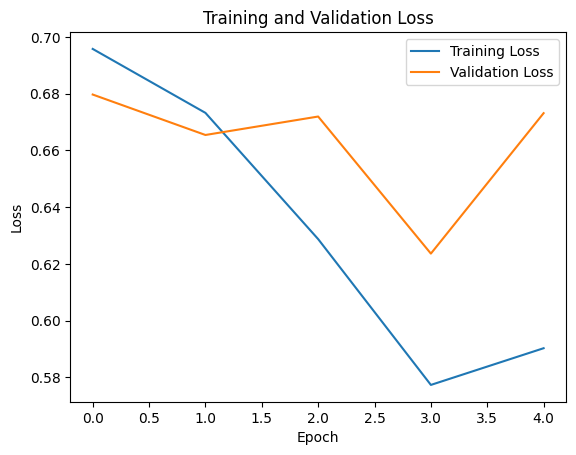

In [21]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


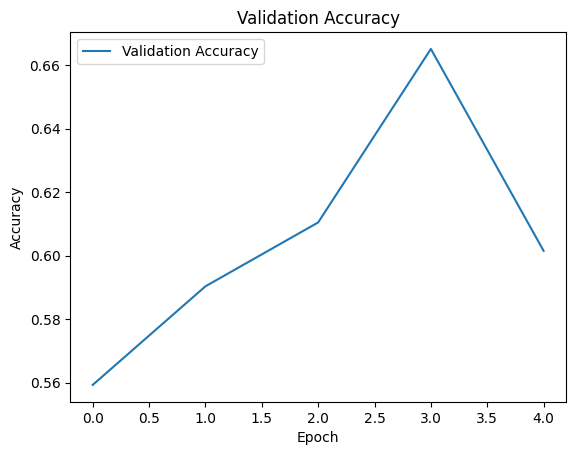

In [22]:
# Plot validation accuracy
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()


In [23]:
def test_model():
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for input_batch, output_batch in tqdm(testloader, total=len(testloader), desc="Testing"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)

            outputs = model(input_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += output_batch.size(0)
            correct += (predicted == output_batch).sum().item()

            loss = criterion(outputs, output_batch)
            test_loss += loss.item()

    accuracy = correct / total
    test_loss /= len(testloader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    return test_loss, accuracy

# test the model
test_loss, test_accuracy = test_model()

print(f"Classification Accuracy on Test Set: {test_accuracy:.4f}")



Testing: 100%|██████████| 628/628 [00:07<00:00, 84.29it/s]

Test Loss: 0.6869, Test Accuracy: 0.5833
Classification Accuracy on Test Set: 0.5833


#### 1.2 Incorporate stemming/lemmatization when doing text preprocessing using the NLTK library. What changes do you observe in accuracy ?

In [24]:
_, word2idx = get_word2idx(train_data['text'], stem=True)


# train_ds = IMDBDataset(imdb_dataset, "train",minlen = 100, maxlen = 500)

train_ds = IMDBDataset(train_data, word2idx, "train", stem=True)
val_ds = IMDBDataset(val_data, word2idx, "validation", stem=True)
test_ds = IMDBDataset(test_data, word2idx, "test", stem=True)

Transforming input text [test]: 100%|██████████| 25000/25000 [02:52<00:00, 145.15it/s]


In [25]:
model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

# create optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Loss function
criterion = nn.CrossEntropyLoss()


In [26]:
train_losses, val_losses, val_accuracy = train_model()

Validation: 100%|██████████| 126/126 [00:01<00:00, 83.71it/s]


Epoch [1/5], Train Loss: 0.6890, Validation Loss: 0.6908, Validation Accuracy: 0.5491


Validation: 100%|██████████| 126/126 [00:01<00:00, 87.63it/s]


Epoch [2/5], Train Loss: 0.6526, Validation Loss: 0.6777, Validation Accuracy: 0.5719


Validation: 100%|██████████| 126/126 [00:01<00:00, 87.00it/s]


Epoch [3/5], Train Loss: 0.6178, Validation Loss: 0.6187, Validation Accuracy: 0.6651


Validation: 100%|██████████| 126/126 [00:01<00:00, 86.31it/s]


Epoch [4/5], Train Loss: 0.5778, Validation Loss: 0.6408, Validation Accuracy: 0.6196


Validation: 100%|██████████| 126/126 [00:01<00:00, 87.12it/s]

Epoch [5/5], Train Loss: 0.5615, Validation Loss: 0.6476, Validation Accuracy: 0.6360


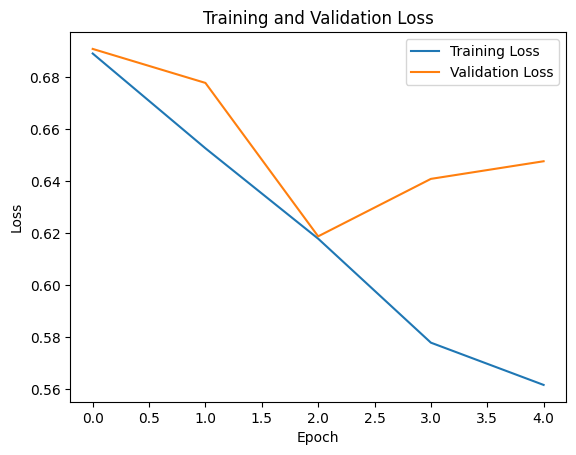

In [27]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


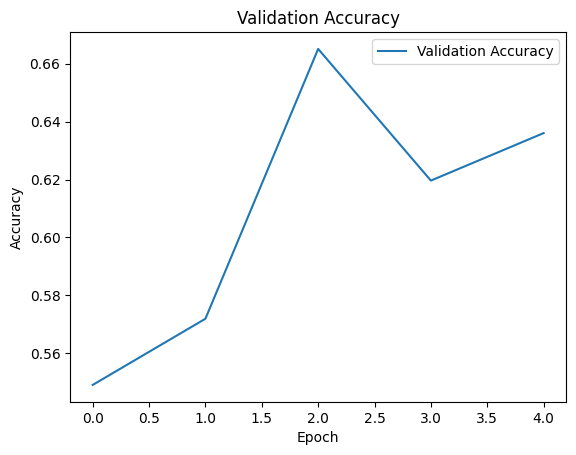

In [28]:
# Plot validation accuracy
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()


In [29]:
test_loss, test_accuracy = test_model()

print(f"Classification Accuracy on Test Set: {test_accuracy:.4f}")

Testing: 100%|██████████| 628/628 [00:07<00:00, 79.58it/s]

Test Loss: 0.6465, Test Accuracy: 0.6326
Classification Accuracy on Test Set: 0.6326


#### 1.3 In the Model class, experiment with only picking the last output and mean of all outputs in the RNN layer. What changes do you observe ?

In [30]:
model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes, mean_output=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Loss function
criterion = nn.CrossEntropyLoss()

Validation: 100%|██████████| 126/126 [00:01<00:00, 115.65it/s]


Epoch [1/5], Train Loss: 0.6960, Validation Loss: 0.6890, Validation Accuracy: 0.5436


Validation: 100%|██████████| 126/126 [00:01<00:00, 113.53it/s]


Epoch [2/5], Train Loss: 0.6777, Validation Loss: 0.6145, Validation Accuracy: 0.6229


Validation: 100%|██████████| 126/126 [00:01<00:00, 116.39it/s]


Epoch [3/5], Train Loss: 0.5979, Validation Loss: 0.4680, Validation Accuracy: 0.8020


Validation: 100%|██████████| 126/126 [00:01<00:00, 116.88it/s]


Epoch [4/5], Train Loss: 0.4796, Validation Loss: 0.4462, Validation Accuracy: 0.8311


Validation: 100%|██████████| 126/126 [00:01<00:00, 117.75it/s]


Epoch [5/5], Train Loss: 0.3188, Validation Loss: 0.3604, Validation Accuracy: 0.8532


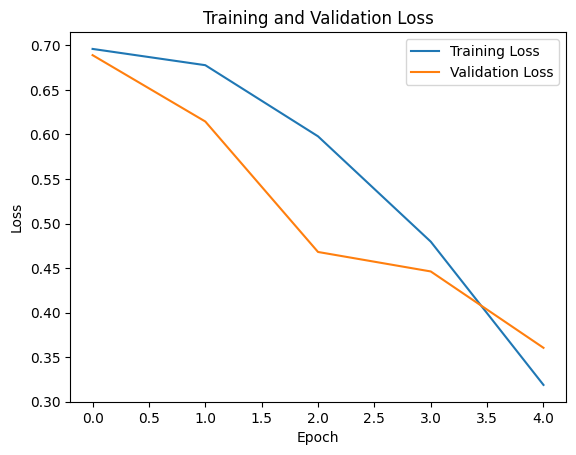

In [31]:
# train the model
train_losses, val_losses, val_accuracy = train_model()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [32]:
test_loss, test_accuracy = test_model()

print(f"Classification Accuracy on Test Set: {test_accuracy:.4f}")


Testing: 100%|██████████| 628/628 [00:05<00:00, 110.85it/s]

Test Loss: 0.3952, Test Accuracy: 0.8297
Classification Accuracy on Test Set: 0.8297


### 2. Hyperparameter Tuning
#### 2.1 Starting with the best configurations based on the above experiments, experiment with 5 different hyperparameter configurations. You can change the size of embedding layer, hidden state, batch in the dataloader.


In [33]:
def create_dataloader(batch_size):
    params = {
        'batch_size': batch_size,
        'shuffle': True,
        'num_workers': 2
    }
    train_dataloader = DataLoader(train_ds, **params)
    val_dataloader = DataLoader(val_ds, **params)
    test_dataloader = DataLoader(test_ds, **params)
    return train_dataloader, val_dataloader, test_dataloader


In [36]:
def create_rnn_model(vocab_size, hidden_size, embedding_dim, num_classes):
    model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes, mean_output=True).to(device)
    return model


Training Model 1 with Hyperparameters Configuration: {'embedding_dim': 128, 'hidden_size': 256, 'batch_size': 32}


Validation: 100%|██████████| 126/126 [00:01<00:00, 111.61it/s]


Epoch [1/5], Train Loss: 0.6926, Validation Loss: 0.6784, Validation Accuracy: 0.5607


Validation: 100%|██████████| 126/126 [00:01<00:00, 110.78it/s]


Epoch [2/5], Train Loss: 0.5916, Validation Loss: 0.5472, Validation Accuracy: 0.7846


Validation: 100%|██████████| 126/126 [00:01<00:00, 114.12it/s]


Epoch [3/5], Train Loss: 0.6752, Validation Loss: 0.6794, Validation Accuracy: 0.5590


Validation: 100%|██████████| 126/126 [00:01<00:00, 111.73it/s]


Epoch [4/5], Train Loss: 0.6810, Validation Loss: 0.6914, Validation Accuracy: 0.5280


Validation: 100%|██████████| 126/126 [00:01<00:00, 107.11it/s]


Epoch [5/5], Train Loss: 0.6368, Validation Loss: 0.5928, Validation Accuracy: 0.6509


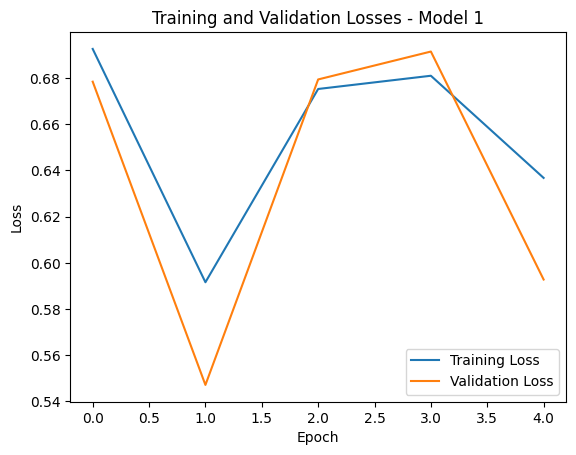

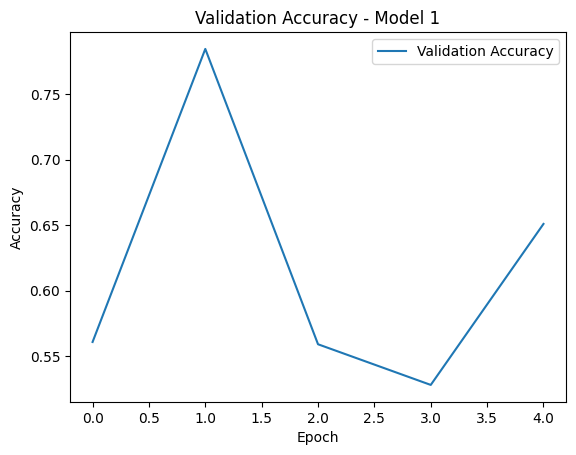

Training Model 2 with Hyperparameters Configuration: {'embedding_dim': 128, 'hidden_size': 512, 'batch_size': 64}


Validation: 100%|██████████| 126/126 [00:01<00:00, 64.10it/s]


Epoch [1/5], Train Loss: 0.6939, Validation Loss: 0.6712, Validation Accuracy: 0.6947


Validation: 100%|██████████| 126/126 [00:01<00:00, 65.82it/s]


Epoch [2/5], Train Loss: 0.5752, Validation Loss: 0.6016, Validation Accuracy: 0.8266


Validation: 100%|██████████| 126/126 [00:01<00:00, 67.52it/s]


Epoch [3/5], Train Loss: 0.4687, Validation Loss: 0.4369, Validation Accuracy: 0.8057


Validation: 100%|██████████| 126/126 [00:01<00:00, 64.40it/s]


Epoch [4/5], Train Loss: 0.4412, Validation Loss: 0.5754, Validation Accuracy: 0.7158


Validation: 100%|██████████| 126/126 [00:01<00:00, 63.92it/s]


Epoch [5/5], Train Loss: 0.5740, Validation Loss: 0.5842, Validation Accuracy: 0.6673


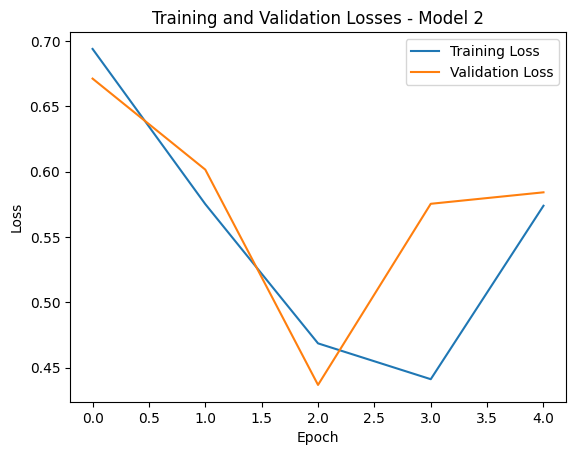

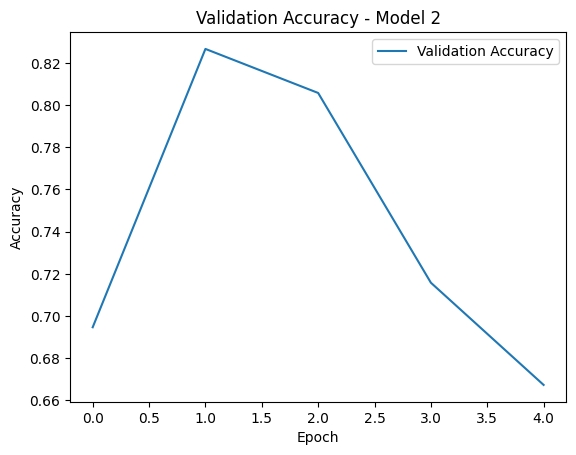

Training Model 3 with Hyperparameters Configuration: {'embedding_dim': 256, 'hidden_size': 512, 'batch_size': 32}


Validation: 100%|██████████| 126/126 [00:02<00:00, 59.97it/s]


Epoch [1/5], Train Loss: 0.7009, Validation Loss: 0.6903, Validation Accuracy: 0.5098


Validation: 100%|██████████| 126/126 [00:01<00:00, 63.51it/s]


Epoch [2/5], Train Loss: 0.6689, Validation Loss: 0.6575, Validation Accuracy: 0.7491


Validation: 100%|██████████| 126/126 [00:01<00:00, 63.70it/s]


Epoch [3/5], Train Loss: 0.4588, Validation Loss: 0.3750, Validation Accuracy: 0.8475


Validation: 100%|██████████| 126/126 [00:01<00:00, 64.35it/s]


Epoch [4/5], Train Loss: 0.2808, Validation Loss: 0.3337, Validation Accuracy: 0.8673


Validation: 100%|██████████| 126/126 [00:01<00:00, 63.04it/s]


Epoch [5/5], Train Loss: 0.1909, Validation Loss: 0.3193, Validation Accuracy: 0.8763


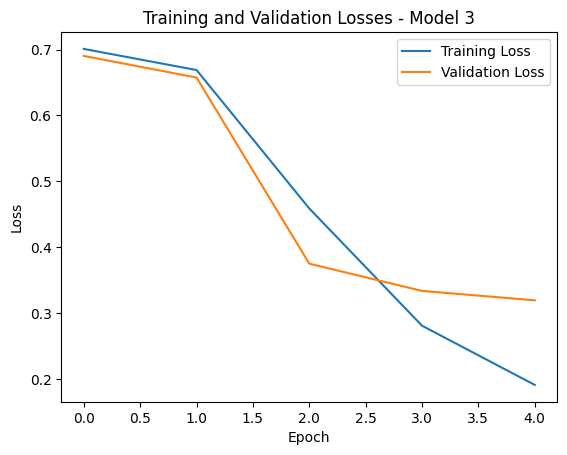

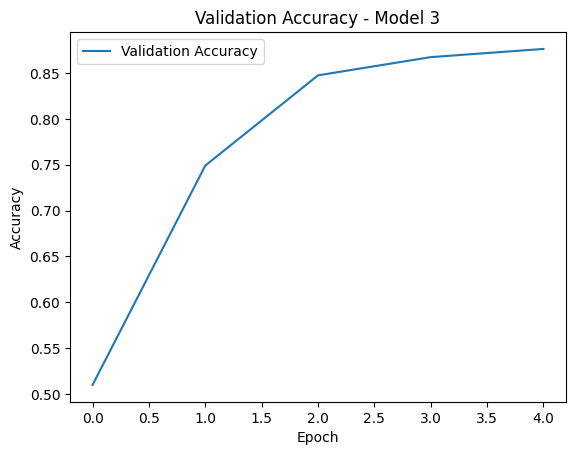

Training Model 4 with Hyperparameters Configuration: {'embedding_dim': 256, 'hidden_size': 256, 'batch_size': 64}


Validation: 100%|██████████| 126/126 [00:01<00:00, 111.97it/s]


Epoch [1/5], Train Loss: 0.6047, Validation Loss: 0.4916, Validation Accuracy: 0.7757


Validation: 100%|██████████| 126/126 [00:01<00:00, 109.68it/s]


Epoch [2/5], Train Loss: 0.3867, Validation Loss: 0.3501, Validation Accuracy: 0.8569


Validation: 100%|██████████| 126/126 [00:01<00:00, 110.96it/s]


Epoch [3/5], Train Loss: 0.2421, Validation Loss: 0.3234, Validation Accuracy: 0.8693


Validation: 100%|██████████| 126/126 [00:01<00:00, 116.92it/s]


Epoch [4/5], Train Loss: 0.1694, Validation Loss: 0.3397, Validation Accuracy: 0.8634


Validation: 100%|██████████| 126/126 [00:01<00:00, 108.46it/s]


Epoch [5/5], Train Loss: 0.1107, Validation Loss: 0.3659, Validation Accuracy: 0.8691


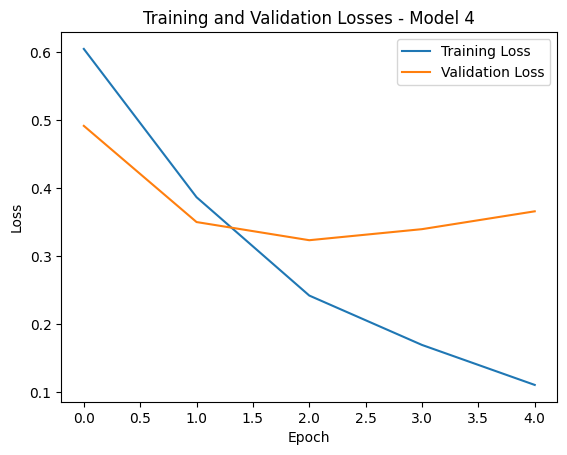

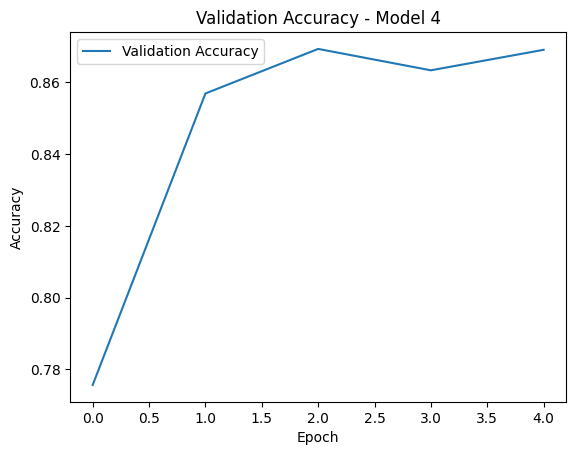

Training Model 5 with Hyperparameters Configuration: {'embedding_dim': 512, 'hidden_size': 512, 'batch_size': 32}


Validation: 100%|██████████| 126/126 [00:02<00:00, 60.53it/s]


Epoch [1/5], Train Loss: 0.6864, Validation Loss: 0.6663, Validation Accuracy: 0.6127


Validation: 100%|██████████| 126/126 [00:02<00:00, 59.69it/s]


Epoch [2/5], Train Loss: 0.6174, Validation Loss: 0.6101, Validation Accuracy: 0.6340


Validation: 100%|██████████| 126/126 [00:02<00:00, 61.17it/s]


Epoch [3/5], Train Loss: 0.5248, Validation Loss: 0.4124, Validation Accuracy: 0.8268


Validation: 100%|██████████| 126/126 [00:02<00:00, 58.44it/s]


Epoch [4/5], Train Loss: 0.4135, Validation Loss: 0.3967, Validation Accuracy: 0.8432


Validation: 100%|██████████| 126/126 [00:02<00:00, 59.17it/s]


Epoch [5/5], Train Loss: 0.5027, Validation Loss: 0.5451, Validation Accuracy: 0.8089


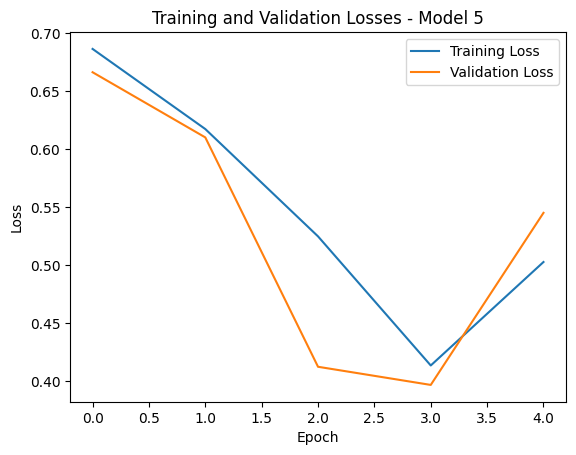

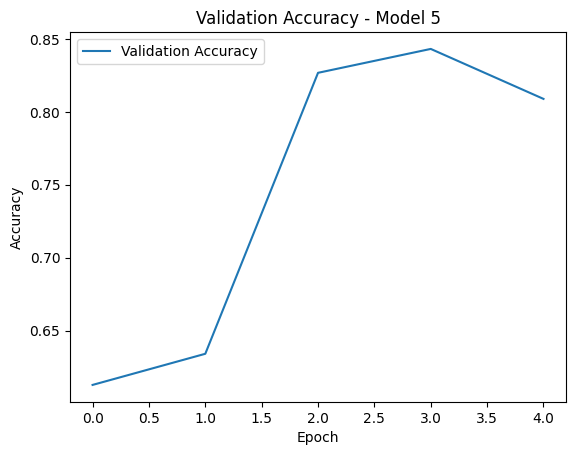

In [37]:
hyperparams_configurations = [
    {'embedding_dim': 128, 'hidden_size': 256, 'batch_size': 32},
    {'embedding_dim': 128, 'hidden_size': 512, 'batch_size': 64},
    {'embedding_dim': 256, 'hidden_size': 512, 'batch_size': 32},
    {'embedding_dim': 256, 'hidden_size': 256, 'batch_size': 64},
    {'embedding_dim': 512, 'hidden_size': 512, 'batch_size': 32}
]

for idx, config in enumerate(hyperparams_configurations):
    print(f"Training Model {idx + 1} with Hyperparameters Configuration: {config}")
    train_dataloader, val_dataloader, test_dataloader = create_dataloader(config['batch_size'])
    model = create_rnn_model(vocab_size, config['hidden_size'], config['embedding_dim'], num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses, val_accuracy = train_model()

    # Plot training and validation losses
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Losses - Model {idx + 1}')
    plt.legend()
    plt.show()

    # Plot validation accuracy
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Validation Accuracy - Model {idx + 1}')
    plt.legend()
    plt.show()


### 3. After RNNs
#### 3.1 Keeping all the parameters same, replace the RNN layer with the LSTM layer using nn.LSTM. What changes do you observe ? Explain why LSTM layer would affect performance.

In [38]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        batch_size, _ = X.size()
        embedded = self.embedding(X)
        output, _ = self.lstm(embedded)
        # Use only the output of the last time step
#         lstm_out = lstm_out[:, -1, :]
#         logits = self.fc(lstm_out)
        
        last_non_zero_indices = torch.tensor([torch.nonzero(row).max() if torch.nonzero(row).size(0) > 0 else 0 for row in X]).to(device)


        last_non_zero_indices = last_non_zero_indices.view(-1, 1)
        embedded = self.embedding(X)
#         output, _ = self.rnn(embedded)
        
        new_output = torch.zeros(batch_size, output.size(2)).to(device)
#         if self.mean_output:
#             output = output.mean(dim=1)
#         else:
        for i in range(batch_size):
            if last_non_zero_indices[i] > 0:
                new_output[i] = output[i, last_non_zero_indices[i], :]
            else:
                new_output[i] = output[i, 0, :]
            
        logits = self.fc(new_output)
        
        
        return logits

Epoch 1: 100%|██████████| 502/502 [00:22<00:00, 22.34it/s]


Epoch 1/5, Loss: 0.6538


Validation: 100%|██████████| 126/126 [00:02<00:00, 57.23it/s]


Epoch [1/5], Train Loss: 0.6538, Validation Loss: 0.8396, Validation Accuracy: 0.5014


Epoch 2: 100%|██████████| 502/502 [00:22<00:00, 22.31it/s]


Epoch 2/5, Loss: 0.5534


Validation: 100%|██████████| 126/126 [00:02<00:00, 58.35it/s]


Epoch [2/5], Train Loss: 0.5534, Validation Loss: 0.4947, Validation Accuracy: 0.7617


Epoch 3: 100%|██████████| 502/502 [00:22<00:00, 22.67it/s]


Epoch 3/5, Loss: 0.3433


Validation: 100%|██████████| 126/126 [00:02<00:00, 58.93it/s]


Epoch [3/5], Train Loss: 0.3433, Validation Loss: 0.3320, Validation Accuracy: 0.8609


Epoch 4: 100%|██████████| 502/502 [00:22<00:00, 22.70it/s]


Epoch 4/5, Loss: 0.1996


Validation: 100%|██████████| 126/126 [00:02<00:00, 59.24it/s]


Epoch [4/5], Train Loss: 0.1996, Validation Loss: 0.3181, Validation Accuracy: 0.8706


Epoch 5: 100%|██████████| 502/502 [00:22<00:00, 22.25it/s]


Epoch 5/5, Loss: 0.1002


Validation: 100%|██████████| 126/126 [00:02<00:00, 57.55it/s]


Epoch [5/5], Train Loss: 0.1002, Validation Loss: 0.4096, Validation Accuracy: 0.8842


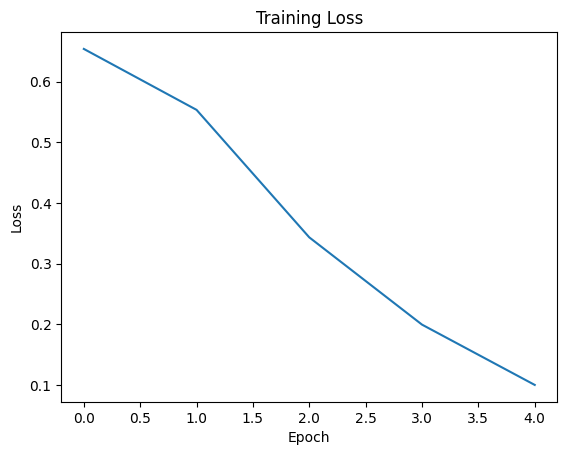

In [39]:
model = LSTMModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training loop
def train_model():
    train_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(trainloader, total=len(trainloader), desc="Epoch {}".format(epoch + 1)):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(trainloader)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")
        
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for input_batch, output_batch in tqdm(valloader, total=len(valloader), desc="Validation"):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)

                outputs = model(input_batch)
                loss = criterion(outputs, output_batch)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += output_batch.size(0)
                correct += (predicted == output_batch).sum().item()

        val_loss = val_running_loss / len(valloader)
        accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracy.append(accuracy)

        # wandb.log({"Validation Loss": val_loss, "Validation Accuracy": accuracy})

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")


    return train_losses

train_losses = train_model()

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


Using an LSTM layer can improve accuracy for a sentiment analysis task with sequences of 100-500 words because LSTMs are designed to capture long-term dependencies in sequential data. This allows the model to consider context over a broader range of words, aiding in better understanding of sentiment nuances within a longer text